In [11]:
from PIL import Image
from PIL import Image
import os
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize, Compose, Normalize, ToTensor, ToPILImage
from transformers import AutoImageProcessor
from transformers import AutoModelForImageClassification
from tqdm.auto import tqdm
from sklearn.metrics import classification_report
import torch_directml
from scores import score_in_details
import shutil

In [2]:
dml = torch_directml.device()

In [3]:
class MyDataset(Dataset):

    def __init__(self, ds, processor):

        self.ds = ds
        self.processor = processor
        self.normalize = Normalize(mean=self.processor.image_mean, std=self.processor.image_std)
        self.size = (self.processor.size["shortest_edge"]
                if "shortest_edge" in self.processor.size
                else (self.processor.size["height"], self.processor.size["width"]))

        self.transform = Compose([Resize(self.size), ToTensor(), self.normalize, ToPILImage()])


    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        image_path = self.ds[idx][0]
        label = self.ds[idx][1]
        image = self.transform(Image.open(image_path).convert("RGB"))
        pixel_values = self.processor(image, return_tensors="pt").pixel_values

        return {"pixel_values": pixel_values.squeeze(),
                "label": label,
                "path": image_path}

In [4]:
checkpoint = "../trained-models/vit"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)
model = AutoModelForImageClassification.from_pretrained(checkpoint, num_labels=2, ignore_mismatched_sizes=True)
model = model.to(dml)

In [5]:
test_dataset = ImageFolder(root="../splitted/test")
test_ds = MyDataset(ds=test_dataset.imgs, processor=image_processor)
test_loader = DataLoader(test_ds, batch_size=20, drop_last=True, shuffle=False)

In [6]:
def get_predictions():
    softmax = nn.Softmax(dim=1)
    model.eval()
    predictions = []
    real_values = []
    pred_probas = []
    misclassified = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            inputs = batch['pixel_values'].to(dml)
            labels = batch['label']
            path = batch['path']

            outputs = softmax(model(inputs).logits)

            _, preds = torch.max(outputs, dim = 1)
            for probs in outputs.cpu():
                pred_probas.append(list(probs.numpy()))

            preds = preds.cpu().numpy()
            labels = labels.numpy()

            predictions.extend(preds)
            real_values.extend(labels)

            for ind, (actual, pred) in enumerate(zip(labels, preds)):
                if actual != pred:
                    misclassified.append((path[ind], actual, pred))

    return predictions, real_values, pred_probas, misclassified

In [7]:
pred, real, probas, misclassified = get_predictions()
print(classification_report(real, pred, digits=6))

  0%|          | 0/943 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0   0.942625  0.940902  0.941762      4924
           1   0.979132  0.979765  0.979448     13936

    accuracy                       0.969618     18860
   macro avg   0.960878  0.960333  0.960605     18860
weighted avg   0.969601  0.969618  0.969609     18860



Accuracy: 96.96182396606575%
Precision: 0.9696008181769491
Recall: 0.9696182396606575
F1-score: 0.9696092477741065
MCC-score: 0.9212114727528692
ROC AUC score: 0.8789504676012242




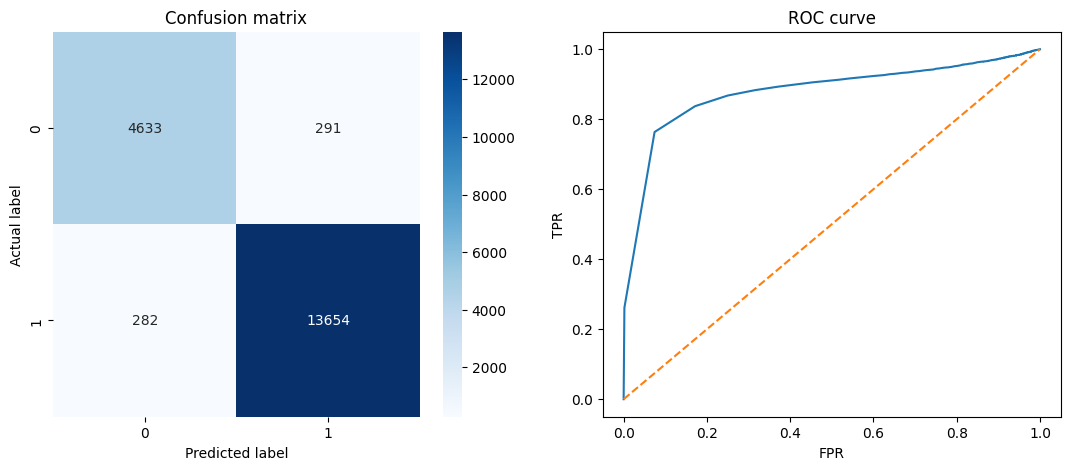

In [10]:
score_in_details(pred=pred, real=real, probas=probas)

In [13]:
dest = "../images/misclassified-new/vit"

if not os.path.exists(dest):
  os.mkdir(dest)

for path, actual, predictd in tqdm(misclassified):
  img_name = path.split("\\")[-1].split(".")[0]
  ext = path.split(".")[-1]
  shutil.copy(path, os.path.join(dest, f"{img_name}_{actual}_{predictd}.{ext}"))

  0%|          | 0/573 [00:00<?, ?it/s]